
# Project: MTA WMWY turnstile analysis

**Program:** mta_women_tech_gala_final_CCHAN.ipynb <br>
**Date:** Jan 8, 2021 <br>
**Desc:** Analyze MTA and Census data to make recommendations on where to deploy canvasers <br>
**Created by:** Joshua Banks, Chuck Cao, Humza Khan, Chris Chan <br>
**Chris Chan specific code. See sections:** <br>
<br>
&emsp;&emsp;&emsp;&emsp;&emsp;**3:** adding income data to stations<br>
&emsp;&emsp;&emsp;&emsp;&emsp;**4:** merge stations/income to turnstile df<br>
&emsp;&emsp;&emsp;&emsp;&emsp;**6c:** graphs for high income stations<br>
&emsp;&emsp;&emsp;&emsp;&emsp;**7:** attemps to improve map <br>
&emsp;&emsp;&emsp;&emsp;&emsp;**8:** testing code
<br>
<br>
**Note: Many many thanks to each of my teammates and (google), particularly for helping with obtaining income data and developing graphs. I relied heavily on their expertise through this process**
<br>

## 1. Prep MTA Turnstile data
### This section was a combined effort of the whole team

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime
import seaborn as sb

In [ ]:
#initialise the number of weeks for the dataset
num_weeks = 4

#initialise the date for the first week of the dataset (week ending on start_date)
start_date = filedate = pd.Timestamp('2019-06-29 00:00:00')

#initialise the regex for the MTA turnstile url
filename_regex = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"

filelist = []

for numfiles in range (num_weeks):

    # create the appropriate filename for the week
    filedate_str = str(filedate.year)[2:4] + str(filedate.month).zfill(2) + str(filedate.day).zfill(2)
    filename = filename_regex.format(filedate_str)

    # read the file and append it to the list of files to be concacated
    #df = pd.read_csv(filename, parse_dates=['DATE'], keep_date_col=True)  
    df = pd.read_csv(filename, keep_date_col=True)
    filelist.append(df)

    # advance to the next week
    filedate += pd.Timedelta(days=7)

df = pd.concat(filelist, axis=0, ignore_index=True)

In [ ]:
df.columns

In [ ]:
# rename columns since the last column, 'EXITS', contains trailing whitespace
df.columns = df.columns.str.replace(r'\s+', '')
df["EXITS"] = pd.to_numeric(df["EXITS"])
df["ENTRIES"] = pd.to_numeric(df["ENTRIES"])

In [ ]:
df['Datetime'] = pd.to_datetime(df.DATE + df.TIME, format='%m/%d/%Y%H:%M:%S')

In [ ]:
# Get counter runs
df['Traffic_running_total']=df['ENTRIES']+df['EXITS']

In [ ]:
# creating DF: grouping by unique turnstile and date to remove dups
turnstiles_4hourly = (df.groupby(["C/A", "UNIT", "SCP", "STATION","LINENAME","Datetime"],as_index=False)).Traffic_running_total.first()

In [ ]:
turnstiles_4hourly.shape

In [ ]:
turnstiles_4hourly.head(10)

In [ ]:
# apply shift of datetime and running total to compute the diff in running total traffic
turnstiles_4hourly[["PREV_TIME", "PREV_Traffic_running_total"]] = (turnstiles_4hourly
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION","LINENAME"])["Datetime", "Traffic_running_total"]
                                                       .apply(lambda grp: grp.shift(1)))

In [ ]:
turnstiles_4hourly.iloc[40:45]

In [ ]:
# create separate hour var
turnstiles_4hourly["Hour"]=pd.to_datetime(turnstiles_4hourly['Datetime']).dt.hour

In [ ]:
# compute traffic per hour
turnstiles_4hourly["Delta_hours"]=pd.to_datetime(turnstiles_4hourly['Datetime']).dt.hour - pd.to_datetime(turnstiles_4hourly['PREV_TIME']).dt.hour
turnstiles_4hourly["People_per_hour"] = (turnstiles_4hourly["Traffic_running_total"] - turnstiles_4hourly["PREV_Traffic_running_total"])/turnstiles_4hourly["Delta_hours"]

In [ ]:
turnstiles_4hourly.iloc[40:45]

In [ ]:
# based on datetime, create numeric and str days of week vars
days_of_week = {0: 'Monday', 1:'Tuesday', 2:'Wednesday',3:'Thursday',4:'Friday', 5:'Saturday', 6:'Sunday'}
turnstiles_4hourly['Day_num'] = [datetime.datetime.weekday(date) for date in turnstiles_4hourly['Datetime']]
turnstiles_4hourly['Day_of_week'] = [days_of_week[datetime.datetime.weekday(date)] for date in turnstiles_4hourly['Datetime']]

In [ ]:
turnstiles_4hourly.iloc[40:45]

In [ ]:
# turnstiles_4hourly['Day_hour'] = 
turnstiles_4hourly["Day_hour"]= turnstiles_4hourly["Day_num"] + (turnstiles_4hourly["Hour"])/24
turnstiles_4hourly.iloc[40:45]

<br>

## 2. Prep Stations Data

In [ ]:
stations = pd.read_csv('http://web.mta.info/developers/data/nyct/subway/Stations.csv')

In [ ]:
stations.sample(10)

In [ ]:
stations['Stop Name'] = stations['Stop Name'].str.upper() 

In [ ]:
# sanity check
stations.sample(5)

In [ ]:
stations.columns

In [ ]:
stations.shape

<br>

## 3. (CChan + Joshua Banks): Adding Income Data to Stations by Lat/Lng
1. import uszipcode package
2. use lat/lng function to pull median hh income from database

#### Other potentially useful variables from the zipcode list:
. zipcode_type='Standard', <br>
. major_city='Derwood', <br>
. county='Montgomery County', <br>
. state='MD', <br>
. radius_in_miles=4.0, <br>
. population=14295, <br>
. population_density=1090.0, <br>
. housing_units=5018, <br>
. occupied_housing_units=4889,  <br>
. median_home_value=453900, <br>
. median_household_income=120603

#### Other interesting metrics from this data can be found here: https://pypi.org/project/uszipcode/

In [ ]:
# uszip method
from uszipcode import SearchEngine
search = SearchEngine(simple_zipcode=False)

In [ ]:
def getincome(_lat,_lon):
    income = search.by_coordinates(_lat,_lon, radius=2,returns=1)[0].median_household_income
    return income

In [ ]:
stations['income'] = stations.apply(lambda row:  getincome(row['GTFS Latitude'], row['GTFS Longitude']) ,axis=1)                                              

In [ ]:
stations.shape

In [ ]:
# check if income is in df
stations.head()

In [ ]:
print(" \nCount total NaN at each column in a Station : \n\n", stations.isnull().sum(), "# row/cols",stations.shape)

In [ ]:
print(stations[stations['income'].isna()]) 

In [ ]:
# checking missing income values
lat=40.764811 
lon=-73.973347

result = search.by_coordinates(lat=lat,lng=lon, radius=5,returns=1)[0].median_household_income    

#### We may have to either impute these values separately with the income from the nearest station (i.e. widen the radius)

### CChan - END OF INCOME MERGE 

<br>

## 4. (CChan): Merge Stations (with income) to Turnstile DF

&emsp;&emsp;(downloaded from: https://qri.cloud/nyc-transit-data/remote_complex_lookupcsv)

&emsp;&emsp;There is no direct link between the stations df and the turnstile df. Therefore we found a link using complex_id from stations and complex_id from xwalk.<br>
&emsp;&emsp;The xwalk contains C/A, Unit, Station, Line to merge with the turnstile data

&emsp;&emsp;**You need to have the .csv file saved in the location of the program**

In [ ]:
station_xwalk = pd.read_csv('booth_station_xwalk.csv')

In [ ]:
station_xwalk.head()

In [ ]:
# complex id is float64 but needs to convert to int. Can only do by filling the nans with 0 first
station_xwalk['complex_id2'] = station_xwalk['complex_id'].fillna(0,inplace=True)
station_xwalk['complex_id2'] = station_xwalk['complex_id'].apply(np.int64)

In [ ]:
station_xwalk.head()

#### 4a. Merge xwalk to stations by complex id

In [ ]:
stations_complex = stations.merge(station_xwalk[["remote","booth","station","complex_id2"]], left_on="Complex ID", right_on="complex_id2")

In [ ]:
stations_complex.shape

In [ ]:
stations_complex.columns

#### 4b. Get unique level stations/ complex data by REMOTE field which will merge back to Turnstile
#### stations_complex_inc = stations_complex.groupby(['remote'])['income'].mean().reset_index()

In [ ]:
stations_complex2 = stations_complex.groupby(['remote'])[['income','GTFS Latitude','GTFS Longitude']].agg('mean').reset_index()

In [ ]:
stations_complex2.columns

In [ ]:
stations_complex2.shape

In [ ]:
stations_complex2.head()

In [ ]:
print("turnstile shape:",turnstiles_4hourly.shape,"stations shape:",stations_complex2.shape)

#### 4c. Merge stations to turnstile DF (remote and unit are the keys)

In [ ]:
turnstiles_4hourly_w_station_info = pd.merge(turnstiles_4hourly, stations_complex2,  how='left', left_on=['UNIT'], right_on = ['remote'])

In [ ]:
print("turnstile shape:",turnstiles_4hourly.shape,"turnstile station shape:",turnstiles_4hourly_w_station_info.shape)

### (CChan) End of section 4: xwalk and merge

<br>

## 5. Clean merged station, turnstile and income data and product final anlaytic DF

In [ ]:
turnstiles_4hourly_w_station_info.head()

In [ ]:
# Remove outliers of turnstile per hour > 10000
turnstiles_4hourly_w_station_info_cleaner = turnstiles_4hourly_w_station_info[ (turnstiles_4hourly_w_station_info["People_per_hour"] >0) & (turnstiles_4hourly_w_station_info["People_per_hour"] < 10000)]

In [ ]:
turnstiles_4hourly_w_station_info_cleaner.columns

In [ ]:
turnstiles_4hourly_w_station_info_cleaner.head()

In [ ]:
# Here we can choose which "station" variable to keep. right now it's from turnstile
turnstile_station = turnstiles_4hourly_w_station_info_cleaner[["STATION", "Datetime", "Day_of_week", "Day_num", "Hour", "Day_hour","People_per_hour","GTFS Latitude","GTFS Longitude","income"]]

In [ ]:
turnstile_station.head()

### END OF Section 5
<br>
<br>

## 6. Analyze data using visuals

## 6a. Graphs for overall traffic in NYC (PLEASE SEE HUMZA KHAN'S CODE)

## 6b. Graphs for Tech + Income in NYC (PLEASE SEE JOSHUA BANKS CODE)

## 6c. (CChan + Joshua Banks) Graphs for high income

In [ ]:
# Very basic plot of lat/long
turnstile_station.plot(kind="scatter", x="GTFS Longitude", y="GTFS Latitude", alpha=0.1, color="blue")

#### CC - This is the lat/long graph (stations as bubbles) and income as color
. Need to fix merge to get data at a unique station level
. Can make something more complex by adding map onto the graph

In [ ]:
import plotly.graph_objects as go
from plotly.graph_objects import Layout
layout = Layout(plot_bgcolor='rgba(0,0,0,0)')

turnstile_station.plot(kind="scatter", x="GTFS Longitude", y="GTFS Latitude",
    s=turnstile_station['People_per_hour']/5, label="Turnstile Traffic",
    c="income", cmap=plt.get_cmap("viridis"),
    colorbar=True, alpha=0.5, figsize=(10,10),
    
)
plt.legend(fontsize=15)
#plt.title('Pedestrian Traffic and Median HH Income by Subway Stations')
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude',fontsize=15)
plt.figtext(.5,.9,'Turnstile Traffic and Median HH Income by NYC Subway Stations', fontsize=20, ha='center')

plt.style.use(['seaborn-bright'])
plt.style.use(['seaborn-white'])

plt.savefig("table1_traffic_inc.png")
plt.show()

#### Top Stations by Income

In [ ]:
station_level = turnstile_station.groupby(['STATION'])[['income','People_per_hour','GTFS Latitude','GTFS Longitude']].agg('mean').reset_index().sort_values(('income'),ascending=False)

In [ ]:
station_level.sort_values(by=['income'],ascending=False)

#### Top 10 Stations by Income

In [ ]:
print(station_level.nlargest(10,['income']))

#### Remove stations clustered (same complex)
We know within the top 10 we have multiple stations WTC in the same complex. 
We can choose one station

In [ ]:
# we know several of our top stations are connected. lets collapse / remove those (i.e. WTC, Etc.)
stations_rm_wtc = station_level[(station_level['STATION'] == ("CITY HALL")) |
                                (station_level['STATION']==("CHAMBERS ST")) |
                                (station_level['STATION']==("CORTLANDT ST")) | 
                                (station_level['STATION']==("WTC-CORTLANDT")) |
                                (station_level['STATION']==("HUNTERS PT AV")) |
                                (station_level['STATION']==("21 ST")) |
                                (station_level['STATION']==("WHITEHALL S-FRY")) |
                                (station_level['STATION']==("SOUTH FERRY")) 
                               ].index 

In [ ]:
stations_rm = station_level.drop(stations_rm_wtc) 

In [ ]:
stations_top10inc = stations_rm.nlargest(10,['income'])

In [ ]:
stations_top10inc.head(20)

#### Print out list of top 10 stations by Income

In [ ]:
# Table 1b
stations_top10inc.to_csv(r'table1b_top10inc_list.csv', index = False)

#### Rescale the people per hour to make point larger

In [ ]:
stations_top10inc['People_per_hour_scale'] = stations_top10inc['People_per_hour']*4

In [ ]:
stations_top10inc.head()

In [ ]:
# Table 2c. Works but no scale
layout = Layout(plot_bgcolor='rgba(0,0,0,0)')

# Top 10 stations by income (1st pass - shows outliers)
y = stations_top10inc["GTFS Latitude"].tolist()
x = stations_top10inc["GTFS Longitude"].tolist()
labels = stations_top10inc['STATION'].tolist()
sm=stations_top10inc['People_per_hour_scale'].tolist()
cm=stations_top10inc['income'].tolist()


# Create the figure and axes objects
fig, ax = plt.subplots(1, figsize=(10,10))
#fig.suptitle('Top 10 Stations by Median HH Income',fontsize=25)

plt.scatter(x,y,
           c=cm,cmap="viridis",
           s=sm,
           alpha=0.5,     # Alpha of the dots
           linewidths=1
           )
plt.colorbar() 

# Add the participant names as text labels for each point
for x_pos, y_pos, label in zip(x, y, labels):
    ax.annotate(label,             # The label for this point
                xy=(x_pos, y_pos), # Position of the corresponding point
                xytext=(0,-20),     # Offset text by 7 points to the right
                textcoords='offset points', # tell it to use offset points
                ha='center',         # Horizontally aligned to the left
                va='center',
                fontsize=10)       # Vertical alignment is centered

# Show the plot
#plt.legend(loc='upper center', bbox_to_anchor=(1,1), fancybox=True, ncol=5, labels=['income'])
#plt.colorbar(cm)
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude',fontsize=15)
plt.savefig("table2_top10_income.svg")
plt.show()

&ensp;&ensp;&ensp;&ensp;**6c. Graphs for tech (PLEASE SEE JOSHUA MAILMAN BANKS AND CHUCK CAO'S CODE)**

<br>

## 7. (CChan): Attempts to improve maps

In [ ]:
import geopandas as gpd

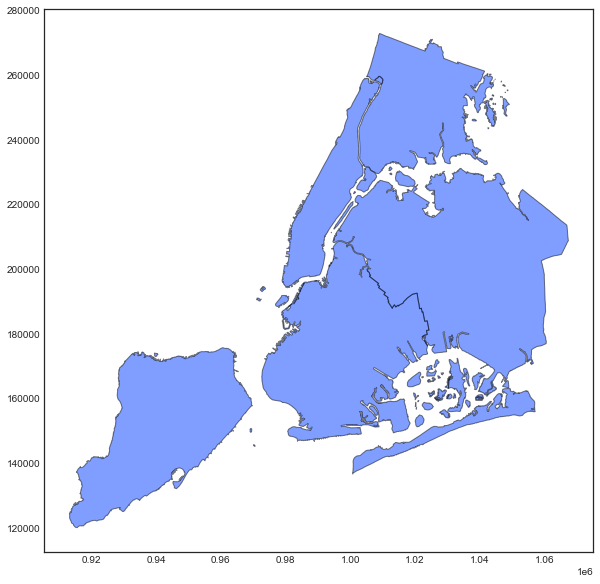

In [216]:
df = gpd.read_file(gpd.datasets.get_path('nybb'))
ax = df.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

In [ ]:
mh=df[df["BoroName"]=="Manhattan"]

In [ ]:
mh.head()

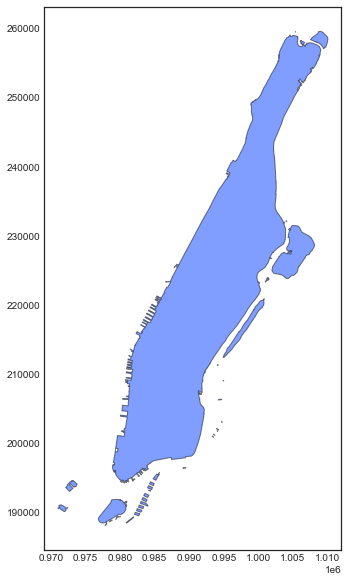

In [217]:
ax = mh.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

In [ ]:
# import libraries
from shapely.geometry import Point, Polygon
#import matplotlib.pyplot as plt
#import street map
street_map = gpd.read_file('/Users/chrischan/Documents/Metis_proj1/pgms/Borough Boundaries/geo_export_2531085b-babd-4126-b357-82b63b5db2a1.shp')

In [ ]:
# designate coordinate system
#crs = {'init':'espc:4326'}
crs=4326

In [215]:
# zip x and y coordinates into single feature
geometry = [Point(xy) for xy in zip(turnstile_station['GTFS Longitude'], turnstile_station['GTFS Latitude'])]
# create GeoPandas dataframe
geo_df = gpd.GeoDataFrame(turnstile_station,
                            crs = crs,
                            geometry = geometry)

In [ ]:
geo_df.head()

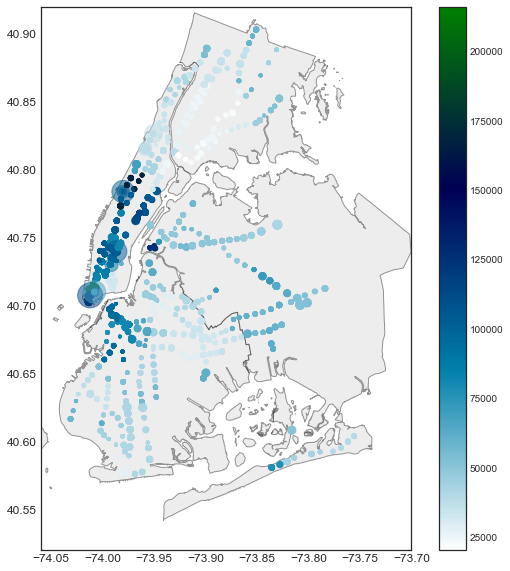

In [218]:
# create figure and axes, assign to subplot
fig, ax = plt.subplots(figsize=(10,10))
# add .shp mapfile to axes

street_map.plot(ax=ax,
                alpha=0.4,
                color='lightgrey',
                edgecolor='k')

# add geodataframe to axes
# assign ioncme/subway variable to represent coordinates on graph
# add legend
# make datapoints transparent using alpha
# assign size of points using markersize

geo_df.plot(column='income',
            ax=ax,
            alpha=0.5,
            legend=True,
            s=geo_df['People_per_hour']/15,
            #markersize=20,
            #colorbar=True,
            cmap=plt.get_cmap("ocean_r"),
            figsize=(10,10)
            )
# add title to graph
# set latitiude and longitude boundaries for map display
#plt.legend(prop={'size':8}
plt.xlim(-74.06,-73.70)
plt.ylim( 40.52,40.92)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)


plt.savefig("table1_traffic_inc_new.svg")

# show map
plt.show()

#### Focus on manhattan top 10 stations

In [ ]:
# zip x and y coordinates into single feature
geometry2 = [Point(xy) for xy in zip(stations_top10inc['GTFS Longitude'], stations_top10inc['GTFS Latitude'])]
# create GeoPandas dataframe
geo_df2 = gpd.GeoDataFrame(stations_top10inc,
                            crs = crs,
                            geometry = geometry2)

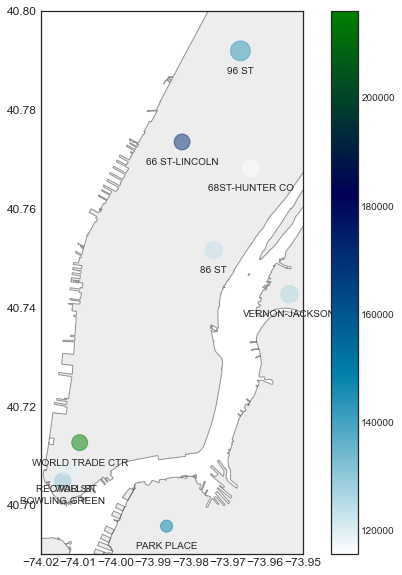

In [214]:
# Create lists for annotation: Top 10 stations by income (1st pass - shows outliers)
y = stations_top10inc["GTFS Latitude"].tolist()
x = stations_top10inc["GTFS Longitude"].tolist()
labels = stations_top10inc['STATION'].tolist()
sm=stations_top10inc['People_per_hour_scale'].tolist()
cm=stations_top10inc['income'].tolist()

# create figure and axes, assign to subplot
fig, ax = plt.subplots(figsize=(10,10))
# add .shp mapfile to axes

street_map.plot(ax=ax,
                alpha=0.4,
                color='lightgrey',
                edgecolor='k')

# add geodataframe to axes
# assign ioncme/subway variable to represent coordinates on graph
# add legend
# make datapoints transparent using alpha
# assign size of points using markersize

geo_df2.plot(column='income',
            ax=ax,
            alpha=0.5,
            legend=True,
            s=geo_df2['People_per_hour']*3,
            #markersize=20,
            #colorbar=True,
            cmap=plt.get_cmap("ocean_r"),
            figsize=(10,10)
            )

# Add the participant names as text labels for each point
for x_pos, y_pos, label in zip(x, y, labels):
    ax.annotate(label,             # The label for this point
                xy=(x_pos, y_pos), # Position of the corresponding point
                xytext=(0,-20),     # Offset text by 7 points to the right
                textcoords='offset points', # tell it to use offset points
                ha='center',         # Horizontally aligned to the left
                va='center',
                fontsize=10)       # Vertical alignment is centered

# add title to graph
# set latitiude and longitude boundaries for map display
plt.xlim(-74.02,-73.95)
plt.ylim( 40.69,40.80)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)



plt.savefig("table2_top10_inc_new.svg")
# show map
plt.show()

## 8. (CChan): Testing Code

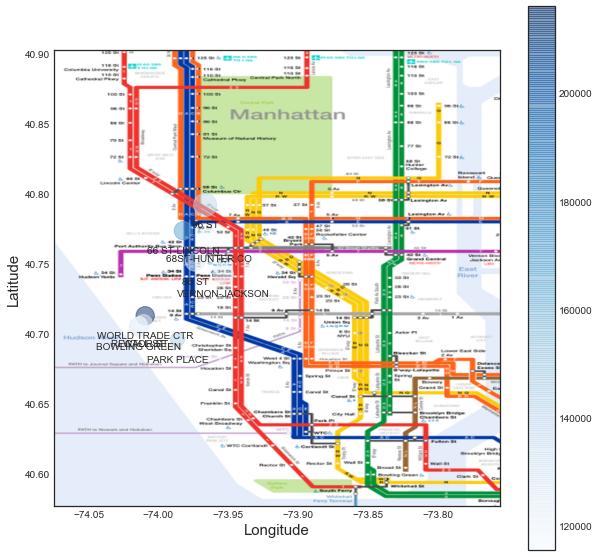

In [219]:
# Table 2c. Works but no scale
import plotly.graph_objects as go
from plotly.graph_objects import Layout
from imread import imread

layout = Layout(plot_bgcolor='rgba(0,0,0,0)')

img=imread('mh1.png')

# Top 10 stations by income (1st pass - shows outliers)
y = stations_top10inc["GTFS Latitude"].tolist()
x = stations_top10inc["GTFS Longitude"].tolist()
labels = stations_top10inc['STATION'].tolist()
sm=stations_top10inc['People_per_hour_scale'].tolist()
cm=stations_top10inc['income'].tolist()


# Create the figure and axes objects
fig, ax = plt.subplots(1, figsize=(10,10))
#fig.suptitle('Top 10 Stations by Median HH Income',fontsize=25)

plt.imshow(img,zorder=0,
           extent=[turnstile_station['GTFS Longitude'].min(),
                   turnstile_station['GTFS Longitude'].max(),
                   turnstile_station['GTFS Latitude'].min(),
                   turnstile_station['GTFS Latitude'].max()])

plt.scatter(x,y,
           c=cm,cmap="Blues",
           s=sm,
           alpha=0.5,     # Alpha of the dots
           linewidths=1
           )
plt.colorbar() 

# Add the participant names as text labels for each point
for x_pos, y_pos, label in zip(x, y, labels):
    ax.annotate(label,             # The label for this point
                xy=(x_pos, y_pos), # Position of the corresponding point
                xytext=(0,-20),     # Offset text by 7 points to the right
                textcoords='offset points', # tell it to use offset points
                ha='center',         # Horizontally aligned to the left
                va='center',
                fontsize=10)       # Vertical alignment is centered

# Show the plot
#plt.legend(loc='upper center', bbox_to_anchor=(1,1), fancybox=True, ncol=5, labels=['income'])
#plt.colorbar(cm)
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude',fontsize=15)
plt.savefig("table2_top10_income.svg")
plt.show()

In [ ]:
import plotly.graph_objects as go
from plotly.graph_objects import Layout
from imread import imread
layout = Layout(plot_bgcolor='rgba(0,0,0,0)')

img=imread('Picture3.png')

plt.imshow(img,zorder=0,
           extent=[turnstile_station['GTFS Longitude'].min(),
                   turnstile_station['GTFS Longitude'].max(),
                   turnstile_station['GTFS Latitude'].min(),
                   turnstile_station['GTFS Latitude'].max()])

ax=plt.gca()
turnstile_station.plot(kind="scatter",
                       x="GTFS Longitude",
                       y="GTFS Latitude",
                       s=turnstile_station['People_per_hour']/5,
                       label="Turnstile Traffic",
                       c="income", 
                       cmap=plt.get_cmap("Blues"),
                       ax=ax,
                       colorbar=True, alpha=0.5, figsize=(10,10),
    
)
plt.legend(fontsize=15)
#plt.title('Pedestrian Traffic and Median HH Income by Subway Stations')
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude',fontsize=15)
plt.figtext(.5,.9,'Turnstile Traffic and Median HH Income by NYC Subway Stations', fontsize=20, ha='center')

plt.style.use(['seaborn-bright'])
plt.style.use(['seaborn-white'])

# plt.savefig("table1_traffic_inc.png")
plt.show()

#### Attempts to test on various images to overlay points

In [ ]:
plt.figure(figsize=(10,10))
img=imread('newyork.png')

plt.imshow(img,zorder=0,
           
           extent=[housing['longitude'].min(),
                   housing['longitude'].max(),
                   housing['latitude'].min(),
                   housing['latitude'].max()])
ax = plt.gca()
housing.plot(x='longitude', 
             y='latitude', 
             kind='scatter', 
             alpha=0.4, 
             s= housing['population']/100, label='population', ax=ax,
             c= 'median_house_value', cmap=plt.get_cmap('jet'), colorbar=True, 
             zorder=5)
plt.legend()
plt.show()

In [ ]:
## Table 2. Working graph of top 10 - no point labels
layout = Layout(plot_bgcolor='rgba(0,0,0,0)')
stations_top10inc.plot(kind="scatter", 
                       x="GTFS Longitude",
                       y="GTFS Latitude",
                       s=stations_top10inc['People_per_hour']*10, 
                       label="Pedestrian Traffic",
                       c="income", cmap=plt.get_cmap("jet"),
                       colorbar=True, alpha=0.5, figsize=(10,10),
    
)
plt.legend(fontsize=15)
#plt.title('Pedestrian Traffic and Median HH Income by Subway Stations')
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude',fontsize=15)
plt.figtext(.5,.9,'Turnstile Traffic and Top 10 Median HH Income by NYC Subway Stations', fontsize=20, ha='center')
plt.savefig("table2_traffic_inc.png")
plt.show()

In [ ]:
## Table 2b. Working graph of top 10 - no point labels
layout = Layout(plot_bgcolor='rgba(0,0,0,0)')

y = stations_top10inc["GTFS Latitude"].tolist()
x = stations_top10inc["GTFS Longitude"].tolist()
labels = stations_top10inc['STATION'].tolist()
sm=stations_top10inc['People_per_hour'].tolist()
cm=stations_top10inc['income'].tolist()


stations_top10inc.plot(kind="scatter", 
                       x="GTFS Longitude",
                       y="GTFS Latitude",
                       s=stations_top10inc['People_per_hour']*10, 
                       label="Pedestrian Traffic",
                       c="income", cmap=plt.get_cmap("jet"),
                       colorbar=True, alpha=0.5, figsize=(10,10),
    
)
for x_pos, y_pos, label in zip(x, y, labels):
    ax.annotate(label,             # The label for this point
            xy=(x_pos, y_pos), # Position of the corresponding point
            xytext=(-10,10),     # Offset text by 7 points to the right
            textcoords='offset points', # tell it to use offset points
            ha='left',         # Horizontally aligned to the left
            va='center',
            fontsize=10)   
    
plt.legend(fontsize=15)
#plt.title('Pedestrian Traffic and Median HH Income by Subway Stations')
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude',fontsize=15)
plt.figtext(.5,.9,'Turnstile Traffic and Top 10 Median HH Income by NYC Subway Stations', fontsize=20, ha='center')
plt.savefig("table2_traffic_inc.png")
plt.show()  


In [ ]:
# Table 2c. Works but no scale
layout = Layout(plot_bgcolor='rgba(0,0,0,0)')

# Top 10 stations by income (1st pass - shows outliers)
y = stations_top10inc["GTFS Latitude"].tolist()
x = stations_top10inc["GTFS Longitude"].tolist()
labels = stations_top10inc['STATION'].tolist()
sm=stations_top10inc['People_per_hour_scale'].tolist()
cm=stations_top10inc['income'].tolist()


# Create the figure and axes objects
fig, ax = plt.subplots(1, figsize=(7,7))
fig.suptitle('Top 10 Stations by Median HH Income',fontsize=20)

ax.scatter(x, y,
           c=cm ,  # Color of the dots (blue)
           s=sm ,         # Size of the dots (50)
           alpha=0.5,     # Alpha of the dots
           linewidths=1,                      
           cmap=plt.get_cmap("rainbow")
          )  # Size of edge around the dots

# Add the participant names as text labels for each point
for x_pos, y_pos, label in zip(x, y, labels):
    ax.annotate(label,             # The label for this point
                xy=(x_pos, y_pos), # Position of the corresponding point
                xytext=(0,-20),     # Offset text by 7 points to the right
                textcoords='offset points', # tell it to use offset points
                ha='center',         # Horizontally aligned to the left
                va='center',
                fontsize=10)       # Vertical alignment is centered

# Show the plot
#plt.legend(loc='upper center', bbox_to_anchor=(1,1), fancybox=True, ncol=5, labels=['income'])
#plt.colorbar(cm)
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude',fontsize=15)
plt.savefig("table2_top10_income.svg")
plt.show()

In [ ]:
# If we had a classification - we would remove lincoln hunters and 96th st

#stations_top10cluster = station_level.nlargest(10,['income'])
stations_top10index = stations_top10inc[(stations_top10inc['STATION'] == ("HUNTERS PT AV")) |
                                        (stations_top10inc['STATION']==("96 ST")) |
                                        (stations_top10inc['STATION']==("66 ST-LINCOLN")) | 
                                        (stations_top10inc['STATION']==("PARK PLACE"))].index 


In [ ]:
stations_top10_cluster = stations_top10inc.drop(stations_top10index) 

In [ ]:
stations_top10_cluster.head(10)

In [ ]:
# Top 7 stations by income (2ND pass - removes outliers)

y = stations_top10_cluster["GTFS Latitude"].unique().tolist()
x = stations_top10_cluster["GTFS Longitude"].unique().tolist()
labels = stations_top10_cluster['STATION'].unique().tolist()
sm=stations_top10_cluster['People_per_hour'].unique().tolist()
cm=stations_top10_cluster['income'].tolist()


# Create the figure and axes objects
fig, ax = plt.subplots(1, figsize=(10,10))
fig.suptitle('Top Subway Station Cluster by Median HH Income',fontsize=20)

# Plot the scatter points
ax.scatter(x, y,
           c=cm ,  # Color of the dots (blue)
           s=sm ,         # Size of the dots (50)
           alpha=0.5,     # Alpha of the dots
           linewidths=1,
           cmap=plt.get_cmap("rainbow")
          )  # Size of edge around the dots

# Add the participant names as text labels for each point
for x_pos, y_pos, label in zip(x, y, labels):
    ax.annotate(label,             # The label for this point
                xy=(x_pos, y_pos), # Position of the corresponding point
                xytext=(-10,-20),     # Offset text by 7 points to the right
                textcoords='offset points', # tell it to use offset points
                ha='left',         # Horizontally aligned to the left
                va='center',
                fontsize=10)       # Vertical alignment is centered

# Show the plot
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude',fontsize=15)
plt.savefig("table3_top_income_cluster.svg")
plt.show()

In [ ]:
# PLACEHOLDER 

y = stations_top10inc["GTFS Latitude"].tolist()
x = stations_top10inc["GTFS Longitude"].tolist()
labels = stations_top10inc['STATION'].tolist()
sm=stations_top10inc['People_per_hour'].tolist()
cm=stations_top10inc['income'].tolist()


# Create the figure and axes objects
fig, ax = plt.subplots(1, figsize=(10,10))
fig.suptitle('Top 10 Stations by Median HH Income',fontsize=20)

# Plot the scatter points
ax.scatter(x, y,
           c=cm ,  # Color of the dots (blue)
           s=sm ,         # Size of the dots (50)
           alpha=0.5,     # Alpha of the dots
           linewidths=1,                      
           cmap=plt.get_cmap("rainbow")
          )  # Size of edge around the dots

# Add the participant names as text labels for each point
for x_pos, y_pos, label in zip(x, y, labels):
    ax.annotate(label,             # The label for this point
                xy=(x_pos, y_pos), # Position of the corresponding point
                xytext=(-10,10),     # Offset text by 7 points to the right
                textcoords='offset points', # tell it to use offset points
                ha='left',         # Horizontally aligned to the left
                va='center',
                fontsize=10)       # Vertical alignment is centered

# Show the plot
ax.legend(cm)
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude',fontsize=15)
plt.savefig("table2_top10_income.svg")
plt.show()

## ------------ CC - END income geo graphs ------------